In [2]:
import os
import glob
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from python_speech_features import mfcc
from sklearn.preprocessing import StandardScaler
from scipy.signal import lfilter
from f0_lib import get_f0

# Filename identifiers

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

* Vocal channel (01 = speech, 02 = song).

* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

* Repetition (01 = 1st repetition, 02 = 2nd repetition).

* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [34]:
emotion_labels = {
    "01": 'neutral',
    "02": 'calm',
    "03": 'happy',
    "04": 'sad',
    "05": 'angry',
    "06": 'fearful',
    "07": 'disgust',
    "08": 'surprised'
}

def load_data(dataset_path):
    emotions = []
    features = []
    for file in glob.glob(dataset_path + 'Actor_*/*.wav'):
        emotions.append(extract_emotion_from_filename(os.path.basename(file)))
        features.append(extract_features(file))
    return np.array(features), np.array(emotions)

def extract_mfcc(audio, sample_rate):
    frame_len = int(2 ** np.floor(np.log2(0.03 * sample_rate)))
    mfccs = mfcc(audio, 
                 sample_rate, 
                 winlen=frame_len / sample_rate, 
                 winstep=frame_len / (2 * sample_rate), 
                 preemph=0.97,
                 numcep=12,
                 winfunc=numpy.hamming)
    return np.mean(mfccs, axis=0)

def extract_emotion_from_filename(filename):
    emotion_code = filename.split('-')[2]
    return emotion_labels[emotion_code]

def pre_emphasize(audio, alpha=0.97):
    return lfilter([1, -alpha], 1, audio)

def get_stft(audio):
    return np.abs(librosa.stft(audio))

def get_mffc(audio, sample_rate):
    return np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40, window=numpy.hamming).T,axis=0)

def get_chroma(stft, sample_rate):
    return np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

def get_mel(audio, sample_rate):
    return np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate).T,axis=0)

def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, duration=2.5, offset=0.6)
    
    # add filter
    audio = pre_emphasize(audio)

    # stft for chroma features
    stft = get_stft(audio)

    result = np.array([])

    mfccs = get_mffc(audio, sample_rate)
    result = np.hstack((result, mfccs))

    chroma = get_chroma(stft, sample_rate)
    result = np.hstack((result, chroma))

    mel = get_mel(audio, sample_rate)
    result = np.hstack((result, mel))
    
    return result

In [48]:
dataset_path = 'ravdess/'
features, emotions = load_data(dataset_path)

In [49]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(stand_features, emotions, test_size=0.2, random_state=42)

print(f'{len(X_train)} samples in training set')
print(f'{len(X_test)} samples in testing set')

"""
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'linear']
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid = GridSearchCV(SVC(), param_grid, n_jobs=-1, refit=True, verbose=2, cv=5)
grid.fit(X_train, y_train)

grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)


grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn, cv=5, n_jobs=-1, verbose=2)
grid_search_knn.fit(X_train, y_train)

print(grid.best_params_)
print(grid_search_rf.best_params_)
print(grid_search_knn.best_params_)"""

1152 samples in training set
288 samples in testing set


"\nparam_grid = {\n    'C': [0.1, 1, 10, 100],\n    'gamma': [1, 0.1, 0.01, 0.001],\n    'kernel': ['rbf', 'poly', 'linear']\n}\n\nparam_grid_rf = {\n    'n_estimators': [100, 200, 300],\n    'max_depth': [None, 10, 20, 30],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n    'bootstrap': [True, False]\n}\n\nparam_grid_knn = {\n    'n_neighbors': [3, 5, 7, 9],\n    'weights': ['uniform', 'distance'],\n    'metric': ['euclidean', 'manhattan', 'minkowski']\n}\n\ngrid = GridSearchCV(SVC(), param_grid, n_jobs=-1, refit=True, verbose=2, cv=5)\ngrid.fit(X_train, y_train)\n\ngrid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)\ngrid_search_rf.fit(X_train, y_train)\n\n\ngrid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn, cv=5, n_jobs=-1, verbose=2)\ngrid_search_knn.fit(X_train, y_train)\n\nprint(grid.best_params_)\nprint(grid_search_rf.best_params_)\nprint(grid_search_knn.best_para

Results for SVM:
Training Accuracy: 0.9895833333333334
Testing Accuracy: 0.6736111111111112

Classification Report:
               precision    recall  f1-score   support

       angry       0.68      0.71      0.70        42
        calm       0.69      0.80      0.74        44
     disgust       0.57      0.75      0.65        32
     fearful       0.80      0.75      0.77        32
       happy       0.55      0.53      0.54        34
     neutral       0.57      0.60      0.59        20
         sad       0.71      0.62      0.66        39
   surprised       0.82      0.60      0.69        45

    accuracy                           0.67       288
   macro avg       0.67      0.67      0.67       288
weighted avg       0.68      0.67      0.67       288

Confusion Matrix:


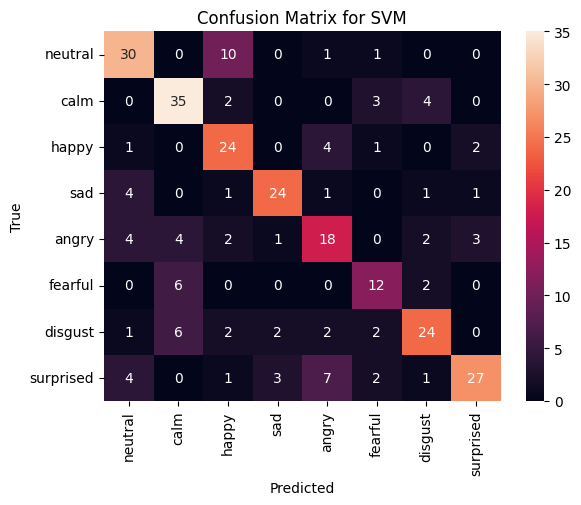

Results for Random Forest:
Training Accuracy: 1.0
Testing Accuracy: 0.5590277777777778

Classification Report:
               precision    recall  f1-score   support

       angry       0.81      0.62      0.70        42
        calm       0.59      0.89      0.71        44
     disgust       0.37      0.69      0.48        32
     fearful       0.59      0.59      0.59        32
       happy       0.34      0.32      0.33        34
     neutral       0.55      0.30      0.39        20
         sad       0.58      0.38      0.46        39
   surprised       0.77      0.51      0.61        45

    accuracy                           0.56       288
   macro avg       0.58      0.54      0.54       288
weighted avg       0.59      0.56      0.56       288

Confusion Matrix:


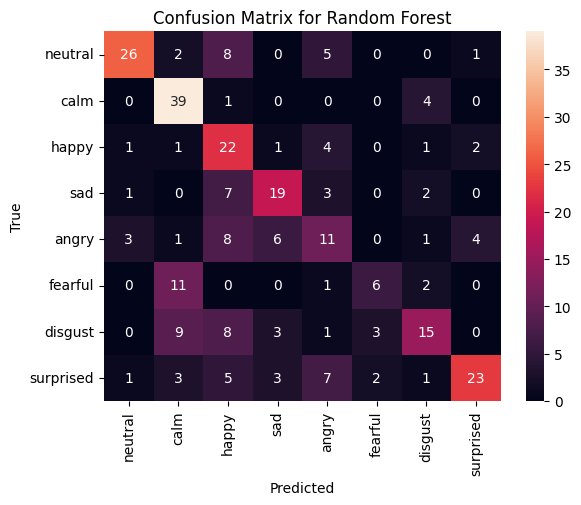

Results for KNN:
Training Accuracy: 1.0
Testing Accuracy: 0.6701388888888888

Classification Report:
               precision    recall  f1-score   support

       angry       0.97      0.67      0.79        42
        calm       0.70      0.80      0.74        44
     disgust       0.70      0.81      0.75        32
     fearful       0.69      0.62      0.66        32
       happy       0.57      0.50      0.53        34
     neutral       0.43      0.65      0.52        20
         sad       0.60      0.62      0.61        39
   surprised       0.70      0.67      0.68        45

    accuracy                           0.67       288
   macro avg       0.67      0.67      0.66       288
weighted avg       0.69      0.67      0.67       288

Confusion Matrix:


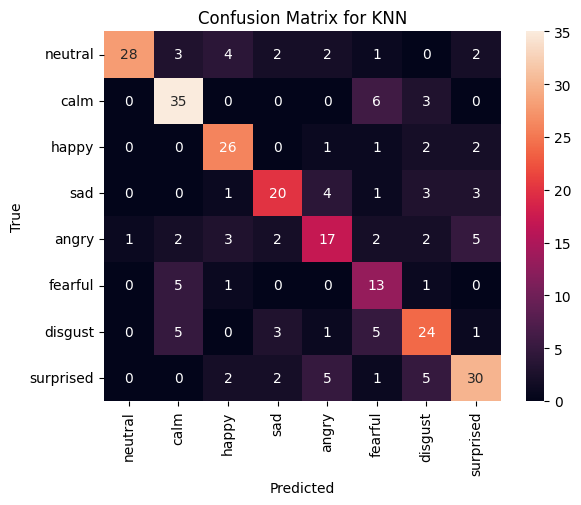

In [52]:

classifiers = {
    'SVM': SVC(kernel='rbf', C=10, gamma=0.01),
    'Random Forest': RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300),
    'KNN': KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
}

def result_helper(name, y_train, y_pred_train, y_test, y_pred):
    emotion_labels_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
    print(f"Results for {name}:")
    print(f"Training Accuracy: {accuracy_score(y_train, y_pred_train)}")
    print(f"Testing Accuracy: {accuracy_score(y_test, y_pred)}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels=emotion_labels_list, yticklabels=emotion_labels_list)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    result_helper(name, y_train, y_pred_train, y_test, y_pred)